# 手动实现 Softmax 与参数调优

## 学习目标
1. **手动实现 Softmax** - 深入理解 softmax 的数学原理和数值稳定性
2. **参数调优实验** - 系统地调整超参数以提升模型性能
3. **实验对比分析** - 学会科学地对比不同配置的效果

## 实验流程
- Part 1: 手动实现 Softmax 函数
- Part 2: 使用自定义 Softmax 构建模型
- Part 3: 参数调优实验
- Part 4: 结果分析与可视化

In [85]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"使用设备: {device}")

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
matplotlib 3.10.6
numpy 2.1.2
pandas 2.3.3
sklearn 1.7.2
torch 2.8.0+cu126
使用设备: cuda:0


## Part 1: 手动实现 Softmax

### 任务1.1：理论复习

Softmax 函数定义：
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

**数值稳定性技巧**：为了避免指数运算溢出，通常会减去最大值：
$$
\text{softmax}(z_i) = \frac{e^{z_i - \max(z)}}{\sum_{j=1}^{K} e^{z_j - \max(z)}}
$$

In [86]:
# TODO: 任务1.1 - 手动实现 Softmax 函数
def my_softmax(logits):
    """
    手动实现 softmax 函数，需要考虑数值稳定性
    
    Args:
        logits: torch.Tensor, shape [batch_size, num_classes]
    
    Returns:
        probs: torch.Tensor, shape [batch_size, num_classes]
        
    提示：
    1. 使用 logits.max(dim=-1, keepdim=True) 找到每行的最大值
    2. 减去最大值后再计算 exp
    3. 除以行和进行归一化
    """
    # ========== 开始编写代码 ==========
    max_values = logits.max(dim=-1, keepdim=True).values
    exp_logits = torch.exp(logits - max_values)
    sum_exp = exp_logits.sum(dim=-1, keepdim=True)
    probs = exp_logits / sum_exp
    return probs
    
    
    # ========== 结束编写代码 ==========

# 测试你的实现
def test_my_softmax():
    print("测试 my_softmax 函数")
    print("=" * 50)
    
    # 测试用例1：简单情况
    logits1 = torch.tensor([[1.0, 2.0, 3.0]])
    my_result1 = my_softmax(logits1)
    torch_result1 = F.softmax(logits1, dim=-1)
    
    print("测试用例1 (简单)：")
    print(f"输入: {logits1}")
    print(f"你的输出: {my_result1}")
    print(f"PyTorch: {torch_result1}")
    print(f"是否一致: {torch.allclose(my_result1, torch_result1, rtol=1e-5)}")
    print(f"输出和为1: {torch.allclose(my_result1.sum(dim=-1), torch.tensor([1.0]))}")
    print()
    
    # 测试用例2：batch 情况
    logits2 = torch.tensor([[1.0, 2.0, 3.0], [0.5, 1.5, 2.5]])
    my_result2 = my_softmax(logits2)
    torch_result2 = F.softmax(logits2, dim=-1)
    
    print("测试用例2 (batch)：")
    print(f"是否一致: {torch.allclose(my_result2, torch_result2, rtol=1e-5)}")
    print()
    
    # 测试用例3：极端值（数值稳定性）
    logits3 = torch.tensor([[100.0, 200.0, 300.0]])
    try:
        my_result3 = my_softmax(logits3)
        torch_result3 = F.softmax(logits3, dim=-1)
        print("测试用例3 (大数值 - 数值稳定性)：")
        print(f"是否一致: {torch.allclose(my_result3, torch_result3, rtol=1e-5)}")
        print(f"是否有 NaN: {torch.isnan(my_result3).any()}")
        print(f"是否有 Inf: {torch.isinf(my_result3).any()}")
    except Exception as e:
        print(f"测试用例3 失败: {e}")
    
    print("\n" + "=" * 50)

# 运行测试
test_my_softmax()

测试 my_softmax 函数
测试用例1 (简单)：
输入: tensor([[1., 2., 3.]])
你的输出: tensor([[0.0900, 0.2447, 0.6652]])
PyTorch: tensor([[0.0900, 0.2447, 0.6652]])
是否一致: True
输出和为1: True

测试用例2 (batch)：
是否一致: True

测试用例3 (大数值 - 数值稳定性)：
是否一致: True
是否有 NaN: False
是否有 Inf: False



### 任务1.2：创建自定义 Softmax 层

将你实现的 softmax 函数封装成一个 PyTorch 层

In [87]:
# TODO: 任务1.2 - 创建自定义 Softmax 层
class MySoftmax(nn.Module):
    """
    自定义 Softmax 层，使用我们手动实现的 softmax 函数
    """
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        # ========== 开始编写代码 ==========
        # 调用 my_softmax 函数
        return my_softmax(x)
        
        # ========== 结束编写代码 ==========

# 测试自定义层
test_layer = MySoftmax()
test_input = torch.randn(2, 10)
output = test_layer(test_input)
print(f"输出shape: {output.shape}")
print(f"每行和为1: {torch.allclose(output.sum(dim=-1), torch.ones(2))}")

输出shape: torch.Size([2, 10])
每行和为1: True


## 数据准备

In [88]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Fashion-MNIST 数据集
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(f"训练集大小: {len(train_ds)}")
print(f"测试集大小: {len(test_ds)}")

训练集大小: 60000
测试集大小: 10000


## Part 2: 构建带有自定义 Softmax 的模型

In [89]:
# 标准模型：输出 logits
class StandardModel(nn.Module):
    def __init__(self, hidden1=300, hidden2=100):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [90]:
# TODO: 任务2.1 - 创建带有自定义 Softmax 的模型
class CustomSoftmaxModel(nn.Module):
    """
    使用自定义 Softmax 层的模型
    注意：这个模型输出概率，不是 logits
    因此需要配合 NLLLoss 使用
    """
    def __init__(self, hidden1=300, hidden2=100):
        super().__init__()
        self.flatten = nn.Flatten()
        # ========== 开始编写代码 ==========
        # 定义网络结构，最后一层使用 MySoftmax
        self.network = nn.Sequential(
            nn.Linear(28 * 28, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 10),
            MySoftmax()
        )
        
        
        # ========== 结束编写代码 ==========

    def forward(self, x):
        # ========== 开始编写代码 ==========
        x = self.flatten(x)
        probs = self.network(x)
        return probs
        
        # ========== 结束编写代码 ==========

## 辅助函数：评估、回调等

In [91]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    """评估函数"""
    loss_list = []
    pred_list = []
    label_list = []
    
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        
        outputs = model(datas)
        loss = loss_fct(outputs, labels)
        loss_list.append(loss.item())
        
        preds = outputs.argmax(axis=-1)
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
    
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [92]:
from torch.utils.tensorboard import SummaryWriter

class TensorBoardCallback:
    """TensorBoard 可视化回调"""
    def __init__(self, log_dir, flush_secs=10):
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def add_scalars(self, step, **kwargs):
        if 'loss' in kwargs and 'val_loss' in kwargs:
            self.writer.add_scalars(
                "training/loss",
                {"train": kwargs['loss'], "val": kwargs['val_loss']},
                global_step=step
            )
        if 'acc' in kwargs and 'val_acc' in kwargs:
            self.writer.add_scalars(
                "training/accuracy",
                {"train": kwargs['acc'], "val": kwargs['val_acc']},
                global_step=step
            )
        if 'lr' in kwargs:
            self.writer.add_scalar("training/learning_rate", kwargs['lr'], global_step=step)
    
    def __call__(self, step, **kwargs):
        self.add_scalars(step, **kwargs)

In [93]:
class EarlyStopCallback:
    """早停回调"""
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
    
    @property
    def early_stop(self):
        return self.counter >= self.patience

## 训练函数

In [94]:
def training(
    model,
    train_loader,
    val_loader,
    epochs,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    early_stop_callback=None,
    eval_step=500,
):
    """训练函数"""
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'steps': []
    }
    
    global_step = 0
    model.train()
    
    with tqdm(total=epochs * len(train_loader), desc="Training") as pbar:
        for epoch in range(epochs):
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(datas)
                loss = loss_fct(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # 评估
                if global_step % eval_step == 0:
                    preds = outputs.argmax(axis=-1)
                    train_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                    
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    model.train()
                    
                    history['train_loss'].append(loss.item())
                    history['train_acc'].append(train_acc)
                    history['val_loss'].append(val_loss)
                    history['val_acc'].append(val_acc)
                    history['steps'].append(global_step)
                    
                    if tensorboard_callback:
                        tensorboard_callback(
                            global_step,
                            loss=loss.item(),
                            val_loss=val_loss,
                            acc=train_acc,
                            val_acc=val_acc,
                            lr=optimizer.param_groups[0]['lr']
                        )
                    
                    if early_stop_callback:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"\n早停于 epoch {epoch}, step {global_step}")
                            return history
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({'epoch': epoch, 'val_acc': history['val_acc'][-1] if history['val_acc'] else 0})
    
    return history

## Part 3: 参数调优实验

### 实验设计
我们将对比以下超参数的影响：
1. **学习率** (lr): 0.0001, 0.001, 0.01, 0.1
2. **批次大小** (batch_size): 16, 32, 64, 128
3. **网络结构** (hidden_size): (128, 64), (256, 128), (512, 256)
4. **优化器**: SGD, Adam
4. **探索**: 鼓励使用其他不同参数探索最优模型

### 任务3.1：学习率调优

In [95]:
# TODO: 任务3.1 - 学习率调优实验
def experiment_learning_rate():
    """
    实验：对比不同学习率的效果
    固定其他参数：batch_size=64, hidden=(256, 128), optimizer=SGD
    """
    print("\n" + "="*70)
    print("实验1：学习率调优")
    print("="*70)
    
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    results = {}
    
    for lr in learning_rates:
        print(f"\n训练 lr={lr}...")
        
        # ========== 开始编写代码 ==========
        # 1. 创建数据加载器 (batch_size=64)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
        val_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)
        
        # 2. 创建模型 (hidden1=256, hidden2=128)
        model = StandardModel(hidden1=256, hidden2=128).to(device)
        
        # 3. 定义损失函数和优化器
        loss_fct = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
        # 4. 创建回调函数
        tb_callback = TensorBoardCallback(log_dir=f"runs/exp_lr_{lr}")
        es_callback = EarlyStopCallback(patience=10)
        
        # 5. 训练模型 (epochs=10)
        history = training(
            model,
            train_loader,
            val_loader,
            epochs=10,
            loss_fct=loss_fct,
            optimizer=optimizer,
            tensorboard_callback=tb_callback,
            early_stop_callback=es_callback,
            eval_step=500
        )

        # 6. 保存结果
        results[lr] = history
        # ========== 结束编写代码 ==========
    
    return results

# 运行实验
lr_results = experiment_learning_rate()


实验1：学习率调优

训练 lr=0.0001...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]


早停于 epoch 5, step 5000

训练 lr=0.001...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]


训练 lr=0.01...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]


训练 lr=0.1...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]

### 任务3.2：批次大小调优

In [96]:
# TODO: 任务3.2 - 批次大小调优实验
def experiment_batch_size():
    """
    实验：对比不同批次大小的效果
    固定其他参数：lr=0.01, hidden=(256, 128), optimizer=SGD
    """
    print("\n" + "="*70)
    print("实验2：批次大小调优")
    print("="*70)
    
    batch_sizes = [16, 32, 64, 128]
    results = {}
    
    for bs in batch_sizes:
        print(f"\n训练 batch_size={bs}...")
        
        # ========== 开始编写代码 ==========
        # 实现批次大小实验
        # 提示：主要改变 DataLoader 的 batch_size 参数
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
        val_loader = torch.utils.data.DataLoader(test_ds, batch_size=bs, shuffle=False)

        model = StandardModel(hidden1=256, hidden2=128).to(device)

        loss_fct = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        tb_callback = TensorBoardCallback(log_dir=f"runs/bs_{bs}")
        es_callback = EarlyStopCallback(patience=10)

        history = training(
            model,
            train_loader,
            val_loader,
            epochs=10,
            loss_fct=loss_fct,
            optimizer=optimizer,
            tensorboard_callback=tb_callback,
            early_stop_callback=es_callback,
            eval_step=500
        )

        results[bs] = history
        # ========== 结束编写代码 ==========
    
    return results

# 运行实验
bs_results = experiment_batch_size()


实验2：批次大小调优

训练 batch_size=16...


Training:   0%|          | 0/37500 [00:00<?, ?it/s]


早停于 epoch 3, step 14000

训练 batch_size=32...


Training:   0%|          | 0/18750 [00:00<?, ?it/s]


早停于 epoch 8, step 16000

训练 batch_size=64...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]


训练 batch_size=128...


Training:   0%|          | 0/4690 [00:00<?, ?it/s]

### 任务3.3：网络结构调优

In [97]:
# TODO: 任务3.3 - 网络结构调优实验
def experiment_architecture():
    """
    实验：对比不同网络结构的效果
    固定其他参数：lr=0.01, batch_size=64, optimizer=SGD
    """
    print("\n" + "="*70)
    print("实验3：网络结构调优")
    print("="*70)
    
    architectures = [
        (128, 64, "小网络"),
        (256, 128, "中网络"),
        (512, 256, "大网络")
    ]
    results = {}
    
    for hidden1, hidden2, name in architectures:
        print(f"\n训练 {name} (hidden1={hidden1}, hidden2={hidden2})...")
        
        # ========== 开始编写代码 ==========
        # 实现网络结构实验
        # 提示：改变 StandardModel 的 hidden1 和 hidden2 参数
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
        val_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

        model = StandardModel(hidden1=hidden1, hidden2=hidden2).to(device)

        loss_fct = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        tb_callback = TensorBoardCallback(log_dir=f"runs/arch_{name}")
        es_callback = EarlyStopCallback(patience=10)
        
        history = training(
            model,
            train_loader,
            val_loader,
            epochs=10,
            loss_fct=loss_fct,
            optimizer=optimizer,
            tensorboard_callback=tb_callback,
            early_stop_callback=es_callback,
            eval_step=500
        )

        results[name] = history
        # ========== 结束编写代码 ==========
    
    return results

# 运行实验
arch_results = experiment_architecture()


实验3：网络结构调优

训练 小网络 (hidden1=128, hidden2=64)...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]


训练 中网络 (hidden1=256, hidden2=128)...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]


早停于 epoch 9, step 9000

训练 大网络 (hidden1=512, hidden2=256)...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]

### 任务3.4：优化器对比

In [98]:
# TODO: 任务3.4 - 优化器对比实验
def experiment_optimizer():
    """
    实验：对比 SGD 和 Adam 优化器
    固定其他参数：lr=0.001, batch_size=64, hidden=(256, 128)
    """
    print("\n" + "="*70)
    print("实验4：优化器对比")
    print("="*70)
    
    optimizers = ['SGD', 'Adam']
    results = {}
    
    for opt_name in optimizers:
        print(f"\n训练使用 {opt_name} 优化器...")
        
        # ========== 开始编写代码 ==========
        # 实现优化器对比实验
        # 提示：
        # if opt_name == 'SGD':
        #     optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        # else:
        #     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
        val_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

        model = StandardModel(hidden1=256, hidden2=128).to(device)

        loss_fct = nn.CrossEntropyLoss()

        if opt_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        tb_callback = TensorBoardCallback(log_dir=f"runs/optimizer_{opt_name}")
        es_callback = EarlyStopCallback(patience=10)

        history = training(
            model, 
            train_loader,
            val_loader,
            epochs=10,  
            loss_fct=loss_fct,
            optimizer=optimizer,
            tensorboard_callback=tb_callback,
            early_stop_callback=es_callback,
            eval_step=500
        )

        results[opt_name] = history    
        # ========== 结束编写代码 ==========
    
    return results

# 运行实验
opt_results = experiment_optimizer()


实验4：优化器对比

训练使用 SGD 优化器...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]


训练使用 Adam 优化器...


Training:   0%|          | 0/9380 [00:00<?, ?it/s]

## Part 4: 结果分析与可视化

### 绘制对比图

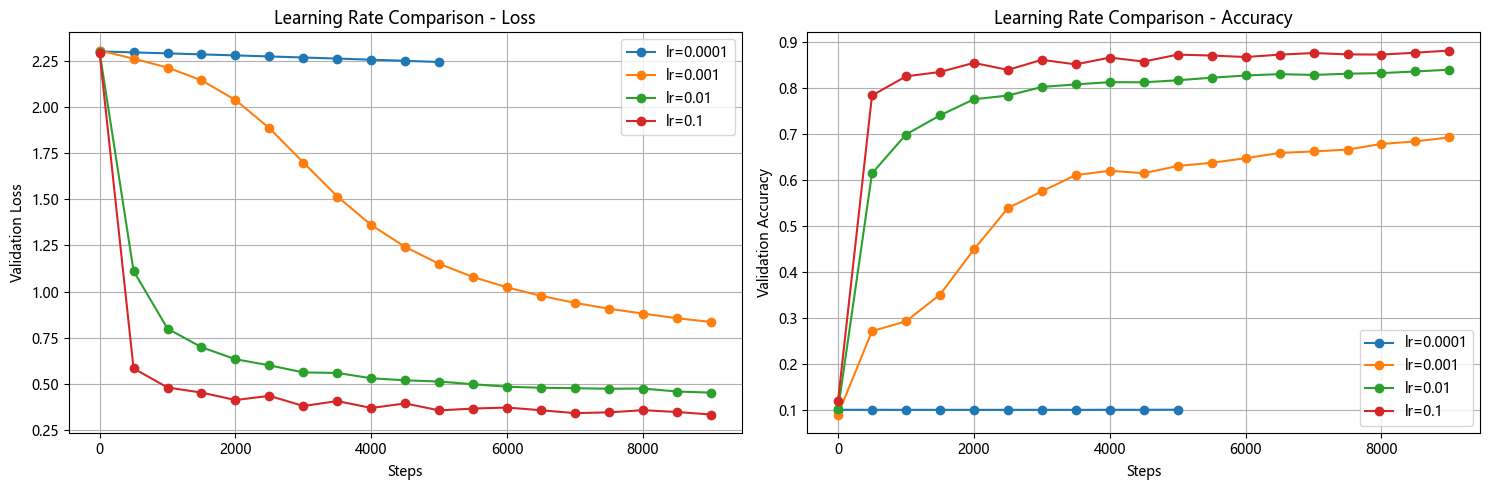

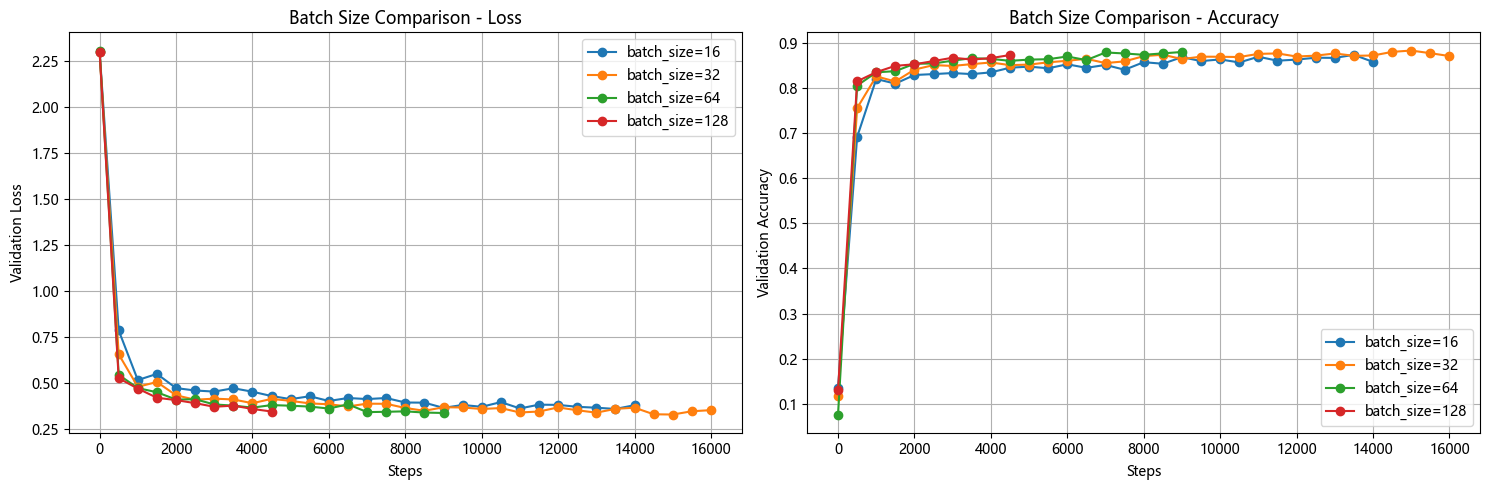

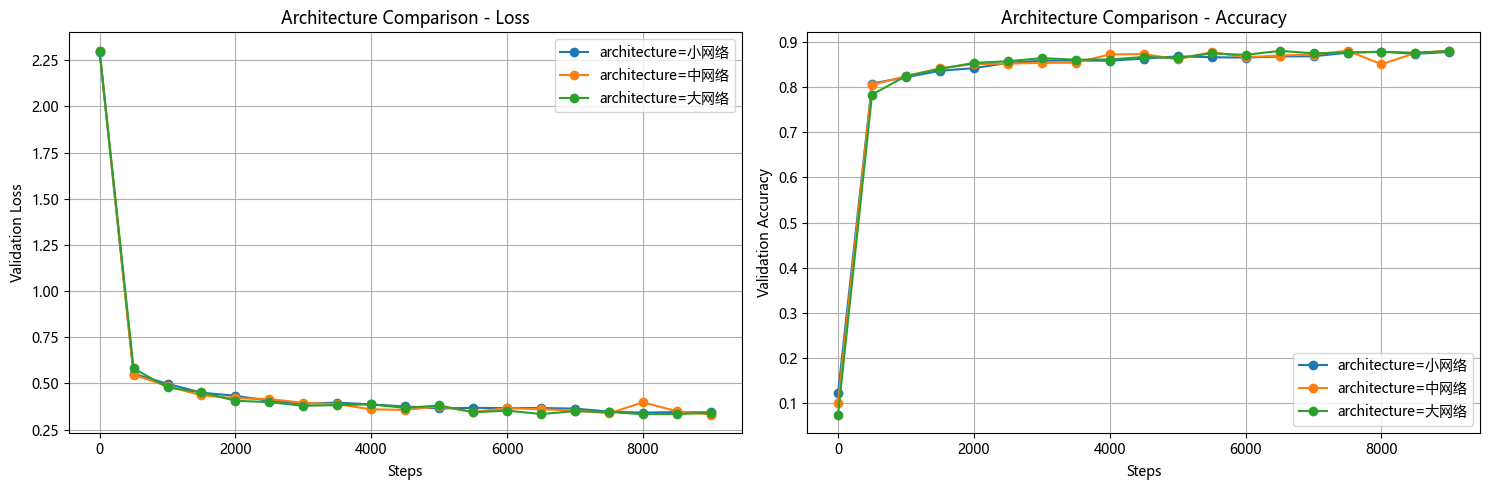

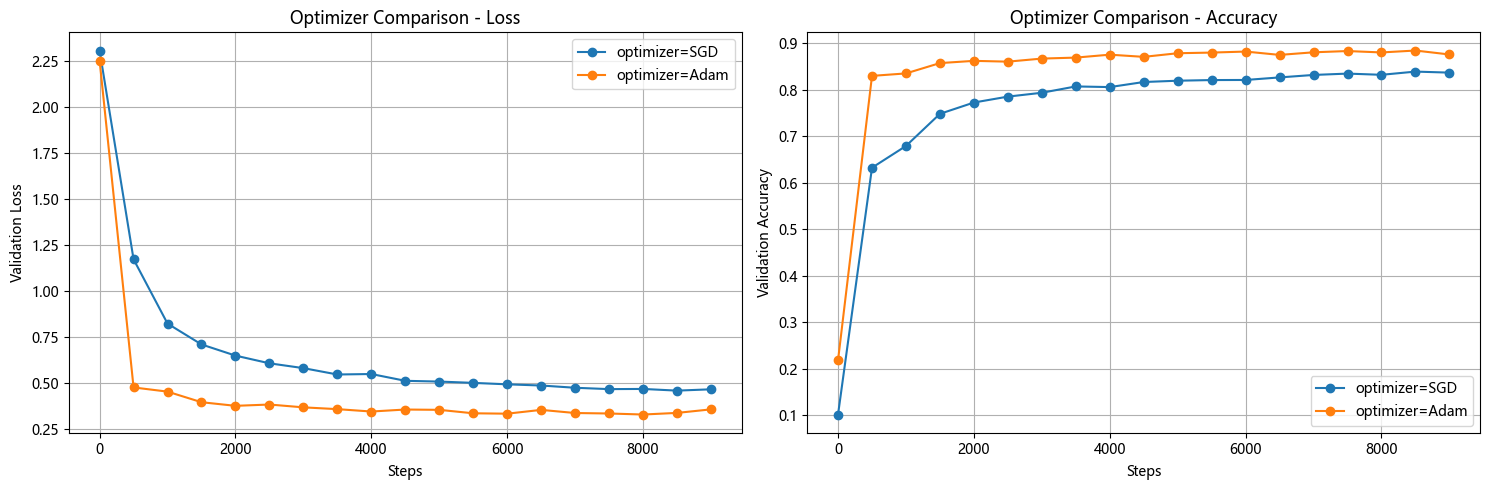

In [99]:
def plot_experiment_results(results_dict, experiment_name, param_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for param_value, history in results_dict.items():
        # 绘制验证损失
        axes[0].plot(history['steps'], history['val_loss'], 
                    label=f'{param_name}={param_value}', marker='o')
        # 绘制验证准确率
        axes[1].plot(history['steps'], history['val_acc'], 
                    label=f'{param_name}={param_value}', marker='o')
    
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_title(f'{experiment_name} - Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Validation Accuracy')
    axes[1].set_title(f'{experiment_name} - Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{experiment_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 使用示例
plot_experiment_results(lr_results, "Learning Rate Comparison", "lr")
plot_experiment_results(bs_results, "Batch Size Comparison", "batch_size")
plot_experiment_results(arch_results, "Architecture Comparison", "architecture")
plot_experiment_results(opt_results, "Optimizer Comparison", "optimizer")

### 汇总最佳结果

In [100]:
def summarize_results(all_experiments):
    summary = []
    
    for exp_name, results in all_experiments.items():
        for param_value, history in results.items():
            best_acc = max(history['val_acc']) if history['val_acc'] else 0
            final_acc = history['val_acc'][-1] if history['val_acc'] else 0
            final_loss = history['val_loss'][-1] if history['val_loss'] else float('inf')
            
            summary.append({
                'Experiment': exp_name,
                'Parameter': str(param_value),
                'Best Val Acc': f"{best_acc:.4f}",
                'Final Val Acc': f"{final_acc:.4f}",
                'Final Val Loss': f"{final_loss:.4f}"
            })
    
    df = pd.DataFrame(summary)
    return df

# 使用示例
all_results = {
    'Learning Rate': lr_results,
    'Batch Size': bs_results,
    'Architecture': arch_results,
    'Optimizer': opt_results
}
summary_df = summarize_results(all_results)
print("\n实验结果汇总:")
print(summary_df.to_string())
summary_df.to_csv('experiment_summary.csv', index=False)
print("\n结果已保存到 experiment_summary.csv")


实验结果汇总:
       Experiment Parameter Best Val Acc Final Val Acc Final Val Loss
0   Learning Rate    0.0001       0.1006        0.1006         2.2435
1   Learning Rate     0.001       0.6928        0.6928         0.8353
2   Learning Rate      0.01       0.8402        0.8402         0.4523
3   Learning Rate       0.1       0.8818        0.8818         0.3337
4      Batch Size        16       0.8733        0.8576         0.3798
5      Batch Size        32       0.8828        0.8706         0.3528
6      Batch Size        64       0.8796        0.8796         0.3374
7      Batch Size       128       0.8728        0.8728         0.3454
8    Architecture       小网络       0.8780        0.8774         0.3429
9    Architecture       中网络       0.8805        0.8805         0.3315
10   Architecture       大网络       0.8798        0.8795         0.3405
11      Optimizer       SGD       0.8390        0.8368         0.4648
12      Optimizer      Adam       0.8843        0.8758         0.3558

结果已保存到 exp

## 训练最佳模型

根据调优实验的结果，使用最佳超参数配置训练最终模型

In [101]:
def train_best_model():
    print("\n" + "="*70)
    print("训练最佳模型")
    print("="*70)
    
    # 根据实验结果选择的最佳参数（示例）
    best_lr = 0.001
    best_batch_size = 64
    best_hidden1 = 512
    best_hidden2 = 256
    best_optimizer = 'Adam'
    
    print(f"\n最佳配置:")
    print(f"  学习率: {best_lr}")
    print(f"  批次大小: {best_batch_size}")
    print(f"  网络结构: ({best_hidden1}, {best_hidden2})")
    print(f"  优化器: {best_optimizer}")
    
    # 创建数据加载器
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=best_batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_ds, batch_size=best_batch_size, shuffle=False)
    
    # 创建模型
    model = StandardModel(hidden1=best_hidden1, hidden2=best_hidden2).to(device)
    
    # 定义损失函数和优化器
    loss_fct = nn.CrossEntropyLoss()
    if best_optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    
    # 创建回调
    tb_callback = TensorBoardCallback("runs/best_model")
    es_callback = EarlyStopCallback(patience=10)
    
    # 训练更多epochs
    history = training(
        model, train_loader, val_loader, epochs=30,
        loss_fct=loss_fct, optimizer=optimizer,
        tensorboard_callback=tb_callback,
        early_stop_callback=es_callback,
        eval_step=500
    )
    
    print(f"\n最终验证准确率: {max(history['val_acc']):.4f}")
    
    # 保存模型
    torch.save(model.state_dict(), 'best_model.pth')
    print("模型已保存到 best_model.pth")
    
    return model, history

# 训练最佳模型
best_model, best_history = train_best_model()


训练最佳模型

最佳配置:
  学习率: 0.001
  批次大小: 64
  网络结构: (512, 256)
  优化器: Adam


Training:   0%|          | 0/28140 [00:00<?, ?it/s]


早停于 epoch 14, step 13500

最终验证准确率: 0.8937
模型已保存到 best_model.pth
